In [33]:
#run this in colab to downgrade sklearn
%pip install scikit-learn==1.3.1


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
%cd mml_flood/

/Users/youngoh/Desktop/flood_urop_repo/mml_flood


/Users/youngoh/Desktop/flood_urop_repo/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### 1. Reading raw data

In [36]:
#gdis data - geocoded disasters
gdis = pd.read_csv('data/disaster/pend-gdis-1960-2018-disasterlocations.csv')
# #emdat data - international disasters
emdat = pd.read_csv('data/disaster/emdat_public_2022_09_21_query_uid-47Yzpr.csv', skiprows=[0,1,2,3,4,5])

/var/folders/1d/zrkty6fd25b94gwy6539wfkw0000gn/T/ipykernel_17648/2624913772.py:4: DtypeWarning: Columns (8,16,17,18,19,24,25,26,27,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  emdat = pd.read_csv('data/disaster/emdat_public_2022_09_21_query_uid-47Yzpr.csv', skiprows=[0,1,2,3,4,5])


In [37]:
# This is where we obtain the statistical features
emdat.head(2)

,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900-9002-CPV,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.077091,NaN,NaN,NaN,NaN
1,1900-9001-IND,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.077091,NaN,NaN,NaN,NaN


In [38]:
# #To do: fix the grid_id, why NLP are only positive, where as GDIS has negative? -> maybe merge using location text?
# df1= gdis[['location','grid_id']]
# df2 = df_nlp[['location','grid_id']]

In [39]:
#select certain columns from emdat and join with gdis
# we grab the disaster number and convert it into string format and grab everything except for the last 4 ( so only the dates)
emdat['disasterno'] = emdat['Dis No'].str[:-4] #format disasterno to merge

#These are the columns that we want to keep  , the features below are left out!
cols = ['disasterno', 'Year', 'Event Name',
#         'Disaster Type', 'Disaster Subtype',
#         'Region', 'Continent', #'Location',
        'Start Year', 'Start Month', 'Start Day',
        'End Year', 'End Month','End Day',
        "Total Damages, Adjusted ('000 US$)"]

emdat = emdat[cols]


In [40]:
#join emdat and gdis into one dataframe
gdis = pd.merge(emdat, gdis, on = 'disasterno', how='right')

In [41]:
gdis.head(3)

,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,level,adm1,adm2,adm3,location,historical,hist_country,disastertype,latitude,longitude
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,3,Shkoder,Shkodres,Ana E Malit,Ana E Malit,0,NaN,flood,42.020948,19.418317
1,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,3,Shkoder,Shkodres,Bushat,Bushat,0,NaN,flood,41.959294,19.514309
2,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,3,Cunene,Cuanhama,Onjiva,Onjiva,0,NaN,flood,-17.093484,15.665758


In [42]:
#print
gdis = gdis.drop_duplicates(subset=['id'])
print('shape', gdis.shape)
gdis.head(2)

shape (9924, 27)


,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,level,adm1,adm2,adm3,location,historical,hist_country,disastertype,latitude,longitude
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,3,Shkoder,Shkodres,Ana E Malit,Ana E Malit,0,NaN,flood,42.020948,19.418317
2,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,3,Cunene,Cuanhama,Onjiva,Onjiva,0,NaN,flood,-17.093484,15.665758


In [43]:
#new grid_id: round to integers
gdis['lat_grid'] = gdis['latitude'].round().astype(int)
gdis['lon_grid'] = gdis['longitude'].round().astype(int)
gdis['grid_id'] = list(zip(gdis['lat_grid'],gdis['lon_grid']))
print('total number of grid pairs', len(gdis.grid_id.value_counts()))

# check if they lie in range
print('lon range', gdis['lon_grid'].min(), gdis['lon_grid'].max())
print('lat range', gdis['lat_grid'].min(), gdis['lat_grid'].max())

total number of grid pairs 2827
lon range -178 180
lat range -54 68


In [44]:
gdis.head(2)

,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,adm3,location,historical,hist_country,disastertype,latitude,longitude,lat_grid,lon_grid,grid_id
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,Ana E Malit,Ana E Malit,0,NaN,flood,42.020948,19.418317,42,19,"(42, 19)"
2,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,Onjiva,Onjiva,0,NaN,flood,-17.093484,15.665758,-17,16,"(-17, 16)"


In [45]:
# #count number of locations in each grid_id: ideally just 1 location per grid_id, if not, I can make grid finer.
# gdis.groupby('grid_id').agg({'location':'nunique'}).sort_values(by='location').value_counts()

In [46]:
# # the grid with most regions
# gdis.loc[gdis['grid_id']==(113, 295)].head(5)

### 2. Construct X

In [47]:
#pivot function: change rows of info into tables
def pivot(df_in, id_col='disastertype', id_list=['Flood']):
    #Drop and reset the index column
    df = df_in.reset_index(drop = True)

    # one set of disaster
    for id in id_list:
        #initialize columns
        df[id+'_bin'] = 0
        df[id+'_amt'] = 0
        df[id+'_ct'] = 0


        # so if the flood happens and we find it, we create these columns and get the flood costs
        df.loc[(df[id_col]==id), id+'_bin'] = 1
        df.loc[(df[id_col]==id), id+'_amt'] = df["Total Damages, Adjusted ('000 US$)"].astype(float)
        df.loc[(df[id_col]==id), id+'_ct'] = 1

    return df


In [48]:
# id_list= df_sub['Disaster Type'].unique()
id_list= gdis['disastertype'].unique().tolist()
print(id_list)
df_pivot= pivot(gdis, id_col = 'disastertype', id_list = id_list)
df_pivot


['flood', 'storm', 'earthquake', 'extreme temperature ', 'landslide', 'volcanic activity', 'drought', 'mass movement (dry)']


,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,landslide_ct,volcanic activity_bin,volcanic activity_amt,volcanic activity_ct,drought_bin,drought_amt,drought_ct,mass movement (dry)_bin,mass movement (dry)_amt,mass movement (dry)_ct
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
1,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
2,2009-0092,2009.0,NaN,2009.0,3.0,1.0,2009.0,4.0,16.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
3,2010-0105,2010.0,NaN,2010.0,3.0,1.0,2010.0,3.0,17.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
4,1995-0082,1995.0,NaN,1995.0,5.0,15.0,1995.0,5.0,15.0,1422569.0,...,0,0,0.0,0,0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9919,1960-0011,1960.0,Manam,1960.0,3.0,17.0,1960.0,3.0,17.0,NaN,...,0,1,NaN,1,0,0.0,0,0,0.0,0
9920,2009-9633,2009.0,NaN,2009.0,NaN,NaN,2010.0,NaN,NaN,NaN,...,0,0,0.0,0,1,NaN,1,0,0.0,0
9921,1990-9289,1990.0,NaN,1990.0,NaN,NaN,1990.0,NaN,NaN,NaN,...,0,0,0.0,0,1,NaN,1,0,0.0,0
9922,1969-9069,1969.0,NaN,1969.0,NaN,NaN,1971.0,NaN,NaN,73867.0,...,0,0,0.0,0,1,73867.0,1,0,0.0,0


In [49]:
df_pivot.columns

Index(['disasterno', 'Year', 'Event Name', 'Start Year', 'Start Month',
       'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Damages, Adjusted ('000 US$)', 'id', 'country', 'iso3', 'gwno',
       'year', 'geo_id', 'geolocation', 'level', 'adm1', 'adm2', 'adm3',
       'location', 'historical', 'hist_country', 'disastertype', 'latitude',
       'longitude', 'lat_grid', 'lon_grid', 'grid_id', 'flood_bin',
       'flood_amt', 'flood_ct', 'storm_bin', 'storm_amt', 'storm_ct',
       'earthquake_bin', 'earthquake_amt', 'earthquake_ct',
       'extreme temperature _bin', 'extreme temperature _amt',
       'extreme temperature _ct', 'landslide_bin', 'landslide_amt',
       'landslide_ct', 'volcanic activity_bin', 'volcanic activity_amt',
       'volcanic activity_ct', 'drought_bin', 'drought_amt', 'drought_ct',
       'mass movement (dry)_bin', 'mass movement (dry)_amt',
       'mass movement (dry)_ct'],
      dtype='object')

In [50]:
#aggregate columns by year
# We need to include the longitude and lattitude here
def aggregate_yrly(df):
    #aggregate count
    col_ct = [col for col in df.columns if '_ct' in col]
    df_ct = df.groupby(['grid_id','year'])[col_ct].agg('sum')

    #aggregate amount
    col_amt = [col for col in df.columns if '_amt' in col]
    df_amt = df.groupby(['grid_id','year'])[col_amt].agg('sum')

    #aggregate binary
    col_bin = [col for col in df.columns if '_bin' in col]
    df_bin= df.groupby(['grid_id','year'])[col_bin].agg('max')

    #join
    df1= pd.concat([df_amt, df_ct], axis=1)
    df_out = pd.concat([df1, df_bin], axis=1)

    return df_out.reset_index()



df_yrly = aggregate_yrly(df_pivot)
# df_yrly.to_csv('data/df_yrly.csv')

In [51]:
df_yrly.columns

Index(['grid_id', 'year', 'flood_amt', 'storm_amt', 'earthquake_amt',
       'extreme temperature _amt', 'landslide_amt', 'volcanic activity_amt',
       'drought_amt', 'mass movement (dry)_amt', 'flood_ct', 'storm_ct',
       'earthquake_ct', 'extreme temperature _ct', 'landslide_ct',
       'volcanic activity_ct', 'drought_ct', 'mass movement (dry)_ct',
       'flood_bin', 'storm_bin', 'earthquake_bin', 'extreme temperature _bin',
       'landslide_bin', 'volcanic activity_bin', 'drought_bin',
       'mass movement (dry)_bin'],
      dtype='object')

In [52]:
print(len(df_yrly))

8691


In [53]:
# # We want to remove years that are before 1979 as we don't have data for those in google earths
# df_yrly = df_yrly.loc[df_yrly['year']>=1979].reset_index(drop=True)
# print(len(df_yrly))

In [54]:
df_yrly.year.min()

1960

### Construct Y Master
look up table for all the previous flood events

In [55]:
bin_col =  [col for col in df_yrly.columns if '_bin' in col]
df_yrly_bin = df_yrly[['grid_id','year'] + bin_col]


In [56]:
# #get a list of disasters and flood_id
# all_dis = gdis[['grid_id','Year','disastertype']]

# #
# flood = all_dis.loc[all_dis['disastertype']=='flood']
# flood

In [57]:
# get a list of grid_ids
grid_id = gdis['grid_id'].unique()
# get a list of year information
print(gdis.Year.min(), gdis.Year.max())
year_id = np.arange(1960, 2019, 1)
#create multi-index: each grid id, spanning over the years
idd = pd.MultiIndex.from_product([grid_id, year_id],
                           names=['grid_id', 'year'])

#length should be |years| * |grid_ids|
print(len(idd))
#get dataframe
idd = idd.to_frame().reset_index(drop=True)


1960.0 2018.0
166793


In [58]:
#master disaster targets for all years and all ids:
#merge with df_yrly
y_master = pd.merge(idd, df_yrly_bin, on=['grid_id','year'], how='left').fillna(0)

#keep just the binary
# y_master.sum(axis=0)

In [59]:
#check:
print(y_master['flood_bin'].sum()) #total number of binary flood targets

#total number of flood incidents:
print(gdis.loc[gdis['disastertype']=='flood'].shape[0])

#the two numbers are slightly different, but that's because some country have more than 1 flood per year



4015.0
4274


In [60]:
# construct next n year target -> look up this table
y_master.head(2)


,grid_id,year,flood_bin,storm_bin,earthquake_bin,extreme temperature _bin,landslide_bin,volcanic activity_bin,drought_bin,mass movement (dry)_bin
0,"(42, 19)",1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(42, 19)",1961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Filter data to previously flooded regions


In [61]:
#step 1: filter xy_df to those grid_ids with previous frequent flooding history
agg = df_yrly.groupby('grid_id').agg({'flood_bin':'sum'})
grid_id_ls = agg.loc[agg['flood_bin']>=2].index.tolist()
print('no of grid_ids selected', len(grid_id_ls))


#step 2: interpolate years to record all years, fill with 0 without any flood using idd
#create multi-index: each grid id, spanning over the years
year_id = np.arange(1960, 2019, 1)
idd = pd.MultiIndex.from_product([grid_id_ls, year_id],
                           names=['grid_id', 'year'])

#length should be |years| * |grid_ids|
print('len of idd', len(idd))
#get dataframe
idd = idd.to_frame().reset_index(drop=True)


no of grid_ids selected 830
len of idd 48970


In [62]:
def attach_target(x_df, y_master, disaster, next_n):
    """
    Attach a 'target' column to x_df based on disaster data in y_master.
    If no data exists in y_master for a given grid_id and year, set the target to NaN.

    Parameters:
    x_df (pd.DataFrame): DataFrame containing grid_id and year.
    y_master (pd.DataFrame): DataFrame containing grid_id, year, and disaster information.
    disaster (str): Column name in y_master indicating disaster occurrence (1 for disaster, 0 otherwise).
    next_n (int): Number of years to look ahead for disasters.

    Returns:
    pd.DataFrame: Updated x_df with a 'target' column.
    """
    # Create a dictionary for fast lookup: {(grid_id, year): disaster_value}
    disaster_lookup = {
        (row['grid_id'], row['year']): row[disaster+'_bin']
        for _, row in y_master.iterrows()
    }

    # Initialize a 'target' column in x_df
    target_col = 'target_' + disaster + '_' + str(next_n)
    x_df[target_col] = np.nan  # Default to NaN

    # Iterate over x_df rows
    for idx, row in x_df.iterrows():
        grid_id = row['grid_id']
        year = row['year']

        # Check if (grid_id, year + next_n + 1) exists in y_master
        if (grid_id, year + next_n ) not in disaster_lookup:
            # No data found for (grid_id, year + next_n + 1), skip this row
            continue

        # Check years from year+1 to year+next_n
        target_found = 0
        for i in range(1, next_n + 1):
            future_year = year + i
            if disaster_lookup.get((grid_id, future_year), 0) == 1:
                target_found = 1
                break

        # Update the 'target' column
        x_df.at[idx, target_col] = target_found
    # Drop rows where 'target' is NaN
    x_df = x_df.dropna(subset=[target_col])

    return x_df

In [63]:
#construct x_stat

#select to those id pass the filtering criteria
x_df = df_yrly.loc[df_yrly['grid_id'].isin(grid_id_ls)]
#interpolate missing years to have no flood
x_df = pd.merge(idd, x_df, on=['grid_id','year'], how='left').fillna(0)
#add back lat and long info
x_df[['lat', 'lon']] = pd.DataFrame(x_df['grid_id'].tolist(), index=x_df.index)
print('length of x_df', len(x_df))

# Rename all columns except 'grid_id' and 'year'
x_df = x_df.rename(columns={col: f'stat_{col}' for col in x_df.columns if col not in ['grid_id', 'year']})

# # Save DataFrame to a CSV file
# x_df.to_csv('data/xy_df/x_stat.csv', index=False)  # Set index=False to avoid saving the index as a column
# y_master.to_csv('data/xy_df/y_master.csv', index=False)
# print("X_Stat, y_master saved to 'dataframe.csv'.")

length of x_df 48970


In [64]:
x_df.to_csv('data/testing/x_stat.csv')

In [65]:
def attach_nlp(xy_df, df_nlp):
    #correct formatting for df_nlp
    df_nlp = string_to_tuple(df_nlp, 'grid_id')
    #drop text, location and label columns
    df_nlp = df_nlp.drop(['location','txt','label','flood_ct'], axis=1)
    #add prefix
    df_nlp = df_nlp.rename(columns={c: 'nlp_' + str(c) for c in df_nlp.columns if c not in ['grid_id']})
    #merge
    xy_df_out = pd.merge(xy_df, df_nlp , on='grid_id', how='left')
    print('shape of xy_df with nlp features', xy_df_out.shape)
    return xy_df_out

#format function for above
def string_to_tuple(df, col):
    try:
        df[col] = df.apply(lambda row: eval(row[col]), axis=1)
    except:
        'error converting to tuple'
    return df

In [66]:
# construct x_nlp
df_nlp = pd.read_pickle('data/nlp/nlp_cls_transfer_new.pkl')
x_nlp = attach_nlp(x_df, df_nlp)

shape of xy_df with nlp features (48970, 61)


In [67]:
x_nlp.to_csv('data/testing/x_nlp.csv')

In [68]:
def attach_era(xy_df, df_era):
    #correct formatting for df_era
    df_era = string_to_tuple(df_era, 'grid_id')
    #drop text, location and label columns
    #add prefix
    # df_era = df_era.rename(columns={c: 'era_' + str(c) for c in df_era.columns if c not in ['grid_id', 'year']})
    #merge
    xy_df_out = pd.merge(xy_df, df_era , on=['grid_id', 'year'])
    print('shape of xy_df with era features', xy_df_out.shape)
    return xy_df_out

In [69]:
x_era = pd.read_csv('data/era5_storage/xy_df_storage1.csv')
x_era = attach_era(x_df, x_era)

shape of xy_df with era features (48970, 508)


In [70]:
x_era.to_csv('data/testing/x_era.csv')

In [72]:
x_full = pd.merge(x_df, x_nlp.drop(x_nlp.filter(regex='stat'), axis=1), on=['grid_id', 'year'])
x_full = pd.merge(x_full, x_era.drop(x_era.filter(regex='stat'), axis=1), on=['grid_id', 'year'])

In [75]:
x_full.to_csv('data/testing/x_full.csv')

In [252]:
#Riley: you can add attach other features here using some old codes, but be careful with merging, and name the features with 'nlp_' and 'era_'
# check there is no redundant features

# #attach nlp to xy_df
# def attach_nlp(xy_df, df_nlp):
#     #correct formatting for df_nlp
#     df_nlp = string_to_tuple(df_nlp, 'grid_id')
#     #drop text, location and label columns
#     df_nlp = df_nlp.drop(['location','txt','label','flood_ct_x'], axis=1)
#     #add prefix
#     df_nlp = df_nlp.rename(columns={c: 'nlp_' + str(c) for c in df_nlp.columns if c not in ['grid_id']})
#     #merge
#     xy_df_out = pd.merge(xy_df, df_nlp , on='grid_id', how='left')
#     print('shape of xy_df with nlp features', xy_df_out.shape)
#     return xy_df_out

# #format function for above
# def string_to_tuple(df, col):
#     try:
#         df[col] = df.apply(lambda row: eval(row[col]), axis=1)
#     except:
#         'error converting to tuple'
#     return df

# #attach era features
# def attach_era(xy_df, df_era):
#     #add prefix
#     df_era = df_era.rename(columns={c: 'era_' + c for c in df_era.columns if c not in ['grid_id','year']})
#     xy_df_out = pd.merge(xy_df, df_era, on=['grid_id','year'], how='left')
#     print('shape of xy_df with era features', xy_df_out.shape)
#     return xy_df_out



In [253]:
# Read the CSV file named 'x'
# df_nlp = pd.read_csv('data/nlp/df_cls_transfer128.csv')

# Read era features

In [1]:
# -------- testing code to be migrated to multimodal_new.ipynb ------

In [2]:
#construct xy_df for appropriate prediction year, depending on the n_pred target period
n_pred = 5

#Riley: attach NLP and ERA features here

# x_df = x_df.loc[x_df['year']>=1979] #crop to after 1979
xy_df = attach_target(x_df, y_master, 'flood', n_pred)
print('length of xy_df', len(xy_df))
print('imbalance', xy_df.filter(regex='target').sum()/len(xy_df))

xy_df.columns

NameError: name 'attach_target' is not defined

In [262]:
#run a fast xgb model on stats only features:

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
#split training and testing
from sklearn.model_selection import train_test_split
import utils


In [257]:
# Random splitting
# Separate features (X) and targets (y)
x = xy_df.drop(xy_df.filter(regex='target').columns, axis=1)  # Drop target columns
x = x.select_dtypes(['number'])  # Keep only numerical columns
y = xy_df.filter(regex='target')  # Keep only target columns


#train_test_split randomly
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print("data imbalance train", y_train.sum()/len(y_train))
print("data imbalance test", y_test.sum()/len(y_test))

# Evaluate the model
y_pred, y_pred_prob = utils.run_xgb(x_train, y_train, x_test)
results['stats only random split'] = utils.get_scores_clf(y_test, y_pred_prob)


data imbalance train target_flood_5    0.245012
dtype: float64
data imbalance test target_flood_5    0.239476
dtype: float64
running xgb...
[10, 20, 65]
Train AUC:  0.8563974915055976
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 20}
maximum f1 score, thres 0.6193620013919782 0.7
auc, f1, accu, accu_bl, precision, recall=  0.8162112347894114 0.6193620013919782 0.6326788636025584 0.73467759079584 0.3781665059592997 0.9304347826086956
[[5511 4715]
 [ 224 2996]]


In [271]:

# results = {}
# Separate features (X) and targets (y)
x = xy_df.drop(xy_df.filter(regex='target').columns, axis=1)  # Drop target columns
x = x.select_dtypes(['number'])  # Keep only numerical columns
y = xy_df.filter(regex='target')  # Keep only target columns

# Get the 'year' column
years = xy_df['year']

# # Determine the split based on years
# min_year, max_year = years.min(), years.max()
# unique_years = np.sort(years.unique())
# split_year = unique_years[int(len(unique_years) * 0.8)]  # 80% split point
# print("split_year is", split_year)

# Split data chronologically
split_year = 2008
train_mask = years <= split_year
test_mask = years > split_year


# #filter to stats only features
# x_stat = x.filter(regex='stat')
# x_stat_nlp = x.filter(regex='stat|nlp')
# print('stat feature no.', x_stat.shape[1])
# print('stat_nlp feature no.', x_stat_nlp.shape[1])

In [272]:
## Cynthia: I'M HERE - THE EXPERIMENT IS NOT WORKING, PROBABY DUE TO VARIABLE NAMING ISSUES.
# SOMEHOW MULTIMODAL (W/ NLP) feature gives the exact same results.

#stat only
x_train1, x_test1 = x1[train_mask], x1[test_mask]
y_train1, y_test1 = y[train_mask], y[test_mask]

print(x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape)
print("data imbalance train", y_train1.sum()/len(y_train1))
print("data imbalance test", y_test1.sum()/len(y_test1))

# Evaluate the model
y_pred, y_pred_prob = utils.run_xgb(x_train1, y_train1, x_test1)
results['stats only chrono split'] = utils.get_scores_clf(y_test1, y_pred_prob)

(40670, 26) (4150, 26) (40670, 1) (4150, 1)
data imbalance train target_flood_5    0.223949
dtype: float64
data imbalance test target_flood_5    0.433494
dtype: float64
running xgb...
[10, 20, 65]
Train AUC:  0.6382152473759951
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 10}
maximum f1 score, thres 0.45902625667393504 0.7
auc, f1, accu, accu_bl, precision, recall=  0.5073786207139512 0.45902625667393504 0.46602409638554215 0.48981817726138793 0.42857794268151067 0.6687048360200111
[[ 731 1620]
 [ 596 1203]]


In [117]:
# #stat_nlp
# x1 = x_stat_nlp.copy()
# x_train1, x_test1 = x1[train_mask], x1[test_mask]
# y_train1, y_test1 = y[train_mask], y[test_mask]

# print(x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape)
# print("data imbalance train", y_train1.sum()/len(y_train1['target_flood_1']))
# print("data imbalance test", y_test1.sum()/len(y_test1['target_flood_1']))

# # Evaluate the model
# y_pred, y_pred_prob = utils.run_xgb(x_train1, y_train1, x_test1)
# results['stat_nlp chrono split'] = utils.get_scores_clf(y_test1, y_pred_prob)

data imbalance train target_flood_1    0.063387
dtype: float64
data imbalance test target_flood_1    0.06031
dtype: float64
running xgb...
[10, 20, 65]
Train AUC:  0.6460304366152158
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 10}
maximum f1 score, thres 0.5578539426523298 0.5
auc, f1, accu, accu_bl, precision, recall=  0.5852580310500348 0.5244485923944082 0.8807644370585791 0.5701789821461157 0.08059317370570726 0.21699196326061998
[[12531  1040]
 [  682   189]]


In [ ]:
# Random splitting
x = x_stat_nlp.copy()

#train_test_split randomly
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# Evaluate the model
y_pred, y_pred_prob = utils.run_xgb(x_train, y_train, x_test) #Riley: generally not a good idea to hardcode numbers like this, better we keep track by having 'nlp_#' on feature names
results['stat nlp random split'] = utils.get_scores_clf(y_test, y_pred_prob)


running xgb...
[10, 20, 65]
Train AUC:  0.64322710670894
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 10}
maximum f1 score, thres 0.557240708954047 0.5
auc, f1, accu, accu_bl, precision, recall=  0.5858471003501506 0.5235203999663379 0.8796565572635369 0.5701266993904829 0.08039119318980051 0.21814006888633755
[[12514  1057]
 [  681   190]]


In [ ]:

results

{'stats only chrono split': (0.5530617333925372,
  0.5397086632788902,
  0.7947426067907996,
  0.5430581031568511,
  0.13174229360566664,
  0.2137546468401487),
 'stat_nlp chrono split': (0.5530617333925372,
  0.5397086632788902,
  0.7947426067907996,
  0.5430581031568511,
  0.13174229360566664,
  0.2137546468401487),
 'stats only random split': (0.5852580310500348,
  0.5578539426523298,
  0.8807644370585791,
  0.5701789821461157,
  0.08059317370570726,
  0.21699196326061998),
 'stat nlp random split': (0.5858471003501506,
  0.557240708954047,
  0.8796565572635369,
  0.5701266993904829,
  0.08039119318980051,
  0.21814006888633755)}

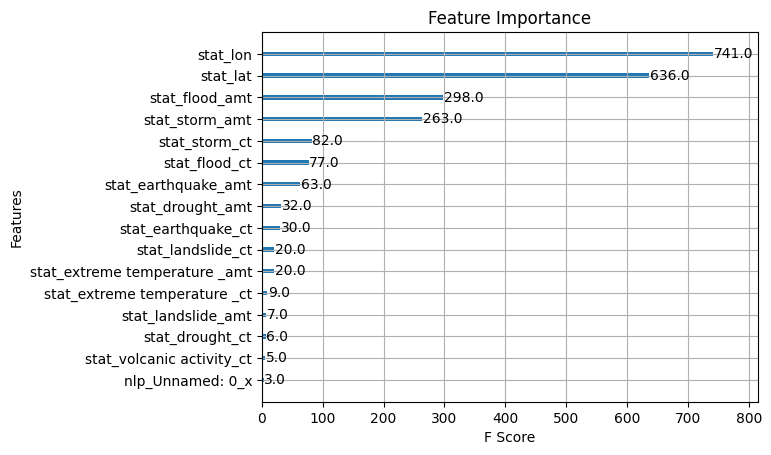

In [ ]:
# Let's see feature importance:

import xgboost as xgb
import matplotlib.pyplot as plt


model = xgb.XGBClassifier()
model.fit(x_train, y_train)

# Plot feature importance
xgb.plot_importance(model, max_num_features=50,importance_type='weight')  # Options: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'

# Customize the plot (optional)
plt.title('Feature Importance')
plt.xlabel('F Score')
plt.ylabel('Features')
plt.show()

In [ ]:
## to do:
#- add ERA and NLP features
#- right now multimodal does not have an edge
